Classfication_Ensemble1 에 이어서 앙상블 학습의 유형에 대해 진행 

## 부스팅 ( Boosting )

* 여러 개의 약한 학습기를 순차적으로 학습-예측 하면서 잘못 예측한 데이터에 가중치 부여를 통해 오류를 개선해 나가면서 학습하는 방식<br><br>
* 부스팅의 대표적인 구현 
    * __AdaBoost__
        * 학습 단계 [참고](https://img1.daumcdn.net/thumb/R800x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbhzSRh%2FbtqKvPnmwWd%2FPM3aRNw5bdfBgn7VPIAUpk%2Fimg.png)
            * ( * ) 와 ( - ) 로 된 피처 데이터 세트 
            * <u>step 1</u> : 첫 번째 약한 학습기가 분류 기준 1로 + 와 - 를 분류
            * <u>step 2</u> : step 1 에서 제대로 분류 되지 못한 오류 데이터들에게 가중치 부여 ( 크기가 커진 + ) 
            * <u>step 3</u> : 두 번재 약한 학습기가 분류 기준 2로 + 와 - 를 분류
            * <u>step 4</u> : step 3 에서 제대로 분류 되지 못한 오류 데이터들에게 가중치 부여 ( 크기가 커진 - )
            * <u>step 5</u> : 세 번 째 약한 학습기가 분류 기준 3으로 + 와 - 를 분류하고 오류 데이터를 찾아서 가중치 부여
            * <u>Last step</u> : 모든 약한 학습기가 순차적으로 가중치를 부여한 예측 결정 기준을 모두 결합해 예측을 수행<br><br>
    * __Gradient Boost = GBM__
        * AdaBoost 와 유사하나 가중치 업데이트로 *경사 하강법*  을 이용한다. <br><br>
        * __경사 하강법__ [[참고] / 회귀에 신경 쓰지 말고 RSS ( cost function ) , Gradient Descent 부분 확인](https://github.com/Jin-Baek/courseraML/blob/main/week1.md)
            * 오류 값 = 실제 값 - 예측 값 
            * 분류의 실제 label 값 : y , 여러 feature 들 : x1 x2 .... , Feature 에 기반한 예측 함수 : F(x)
            * 오류식 h(x) = y - F(x) 을 반복 수행을 통해서 최소화 할 수 있도록 가중치를 업데이트 시켜주는 기법<br><br>
    * __더 개선된 기능을 제공하는 XGBoost, LightGBM, Stacking__
                   
        

## GBM ( Gradient Boosting Machine ) 

앞서  [실습] 사용자 행동 인식 예측에서 사용했던 데이터를 가져오기 위해 두 개의 함수를 그대로 가져와서 GBM 성능 평가를 진행했다.

In [3]:
from sklearn.ensemble import GradientBoostingClassifier
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time
import warnings
warnings.filterwarnings('ignore')

def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),columns=['dup_cnt']) 
    feature_dup_df = feature_dup_df.reset_index() # column name 으로 되어 있는 index reset 
    
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(),feature_dup_df,how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name','dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1])
                                                                                             if x[1]>0 else x[0],axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'],axis=1)
    return new_feature_name_df

def get_human_activity_recognition_dataset():
    feature_name_df = pd.read_csv("UCI_HAR_Dataset/features.txt",sep='\s+',header=None, names=['column_index','column_name'])
    # 컬럼명 중복 처리
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # 전처리된 feature 들을 학습, 테스트 dataset 의 feature 로 넣어줘야 해서 list 로 변환
    feature_name = new_feature_name_df.iloc[:,1].values.tolist()
    
    X_train = pd.read_csv("UCI_HAR_Dataset/train/X_train.txt",sep='\s+',header=None, names=feature_name)
    X_test = pd.read_csv("UCI_HAR_Dataset/test/X_test.txt",sep='\s+',header=None, names=feature_name)
    
    y_train = pd.read_csv("UCI_HAR_Dataset/train/y_train.txt",sep='\s+',header=None, names=['action'])
    y_test = pd.read_csv("UCI_HAR_Dataset/test/y_test.txt",sep='\s+',header=None, names=['action'])
    
    return X_train , X_test, y_train, y_test

##  Main
X_train, X_test, y_train, y_test = get_human_activity_recognition_dataset()

start_time = time.time()
gb_clf = GradientBoostingClassifier(random_state=81)

gb_clf.fit(X_train,y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test,gb_pred)

print('GBM 정확도: {0:.4f}'.format(gb_accuracy))
print('GBM 수행 시간:{0:.1f} 초'.format(time.time()-start_time))

GBM 정확도: 0.9389
GBM 수행 시간:516.7 초


GBM 을 기본 파라미터로 진행하였을 때, Random forest 보다 약간 높은 정확도가 도출 되었으나, 학습에 너무 많은 수행 시간이 필요하다.<br>
이번에는 GridSearchCV 로 하이퍼 파라미터 튜닝을 진행해보자.<br>
* 하이퍼 파라미터 EX)
    * loss : 경사 하강법에서 사용할 비용 함수 지정. 기본값은 deviance
    * learning_rate : 학습률 = α / 위 경사하강법 참고 링크 확인 ! 
    * n_estimators : 약한 학습기의 갯수. 기본값 100. 많을 수록 성능 ↑ 이지만 수행시간도 ↑\
    * subsample : 약한 학습기가 학습에 사용하는 데이터의 샘플링 비율/ 기본값 1


In [ ]:
from sklearn.model_selection import GridSearchCV
import time

start_time = time.time()
params = {
    'n_estimators':[100,300],
    'learning_rate':[0.05,0.1]
}

grid_cv = GridSearchCV(gb_clf,param_grid=params,cv=2,verbose=0)
grid_cv.fit(X_train,y_train)
print('최적의 파라미터:\n',grid_cv.best_params_)
print('최고 정확도: {0:.4f}'.format(grid_cv.best_score_))
print('수행 시간 : {0:.2f} 초',time.time()-start_time)

GBM 은 과적합에도 뛰어난 예측 성능을 가진 알고리즘이다.<br> 다만 위 예제를 실행해보면 알 수 있듯이 수행 시간이 너무 오래 걸린다는 단점이 있다. <br>그래서 이 문제를 보완 할 수 있는 알고리즘 XGBoost 와 LightGBM 이 등장했다.

## XGBoost 

GBM 을 기반으로 GBM의 단점을 해결한 알고리즘.
#### 주요 기능 [참고](https://images.velog.io/images/dbj2000/post/2bab6ce7-9f86-40ce-8371-d97731b01cab/image.png)
* 뛰어난 예측 성능 
* GBM 대비 빠른 수행 시간 : GBM 은 순차적으로 가중치를 증감하는 방법이지만, XGBoost 는 병렬적으로 수행해서 빠르게 학습이 가능 <br>
단, Random forest 보다 빠른 것은 아님
* 과적합 규제 기능 추가 
* Tree pruning : 더 이상 긍정 이득이 없는 분할을 가지치기 해서 분할 수를 더 줄이는 기능 
* 자체 내장된 교차검증 : 조기 중단 기능 있음
* 결손값 자체 처리 

XGBoost 는 <br>
* XGBoost 고유의 프레임워크를 파이썬 기반에서 구현한 별도의 API : __파이썬 래퍼 XGBoost 모듈__ → 고유의 API 와 하이퍼 파라미터 사용 
* 사이킷런과 연동되는 모듈 : __사이킷런 래퍼 XGBoost 모듈__ → 지금까지 사용한 다른 estimator 과 같은 사용법 <br>

로 나뉜다.

### 파이썬 래퍼 XGBoost 하이퍼 파라미터

GBM 의 하이퍼 파라미터와 동일하나, 몇 가지가 추가되었다.<br> 자체적인 프레임 워크로 교차검증, 성능 평가, 피쳐 중요도 등의 시각화 기능을 가지고 있다.<br>참고로 사이킷런 래퍼 XGBoost 모듈과 같은 기능을 해도 파라미터 명칭이 다를 수 있음에 유의하자. <br><br>
하이퍼 파라미터 각 각에 대한 정보는 p.231, 232 를 참고하자. 그 외 알아둘 점은 간략하게 정리한다.<br><br>
<u>과적합 문제가 심각하다면</u>,

   * eta = learning rate 값 낮추고 num_round = n_estimator 값 높이기 
   * max_depth 값 낮추기 
   * min_child_weight 값 높이기 
   * gamma 값 높이기 
    
<span style="color:red"><주요 기능 중 하나></span><br>기본 GBM 의 경우 n_estimators 에 지정된 횟수 만큼 반복적으로 학습 오류를 감소 시키며 학습을 진행하면서 지정된 횟수를 다 완료 해야하는 반면,<br> XGBoost 와 LightGBM 은 __조기 중단 기능__ 이 있어서 n_estimator 에 지정한 반복 횟수에 도달하지 않더라도 조기 중단 파라미터로 예측 오류가 더 이상 개선 되지 않으면 반복을 중지해서 수행 시간을 개선 할 수 있다.<br><br>
사이킷런 내장 dataset 위스콘신 유방암 데이터로 실습을 진행한다.

In [142]:
# 파이썬 래퍼 XGBoost 모듈 ( 별도 설치 필요 ) 
import xgboost as xgb
# 피처 중요도를 시각화 해주는 모듈 
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
X_feature = dataset.data
y_label = dataset.target
cancer_df = pd.DataFrame(data=X_feature,columns=dataset.feature_names)
cancer_df['target']=y_label

cancer_df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


해당 dataset 의 label 값의 분포 확인하기

In [124]:
cancer_df['target'].value_counts()

1    357
0    212
Name: target, dtype: int64

유방암에 대한 양성이 357 개, 음성이 212로 구성되어 있다.<br>
모델링을 위해 학습, 테스트 데이터로 나누자.

In [143]:
X_train,X_test, y_train,y_test = train_test_split(X_feature,y_label,test_size=0.2,random_state=71)
print(X_train.shape,X_test.shape)

(455, 30) (114, 30)


파이썬 래퍼 XGBoost 는 numpy 입력 파라미터를 받아서 만들어지는 XGBoost 전용 데이터 세트인 <u>DMatrix</u> 를 학습과 테스트 데이터에 이용한다.<br>
( 참고로 사이킷런 래퍼 XGBoost 는 그동안 연습했던 estimator 와 동일하게 사용된다. )<br><br>
만약 pandas Dataframe 의 데이터를 Dmatrix 로 변환하려면 DataFrame.values 로 numpy 로 변환 한 뒤에 DMatrix 에 적용 가능하다. 

In [144]:
dtrain = xgb.DMatrix(data=X_train,label=y_train)
dtest = xgb.DMatrix(data=X_test,label=y_test)

params = {'max_depth':3,
         'eta':0.1,
         'objective':'binary:logistic',
         'eval_metric':'logloss'
         }
num_rounds = 400 

추가로 위 코드에서 XGBoost 의 하이퍼 파리미터를 조정 해주기 위한 딕셔너리를 만들었다.<br>
* max_depth : 트리 최대 깊이 
* eta : learning rate = 학습률
* objective  목적 함수 / binary:logistic 이진 로지스틱 ( 예제 데이터가 0 또는 1 인 이진분류 이므로 )
* eval_metric : 오류 함수의 평가 성능 지표 
* num_rounds : 부스팅 반복 횟수 

<u>파이썬 래퍼 XGBoost</u> 같은 경우에는 하이퍼 파라미터를 Estimator 의 생성인자로 전달했던 사이킷런의 경우랑 조금 다르다.<br>
학습 수행을 위한 train() 함수에 하이퍼 파라미터를 전달한다. <br><br><span style="color:red">현재 위치 Markdown 셀 기준으로 위는 XGBoost 의 하이퍼 파리미터, 아래는 train() 의 파라미터 임을 유의하자.</span><br>
이 때, 조기 중단을 위해 early_stopping_rounds 파라미터를 써주게 될 경우 반드시 eval_set , eval_metric 도 함께 설정 해 주어야 한다.
* eval_set 는 성능 평가를 수행 할 평가용(eval=test) 데이터 세트를 설정 → evals 파라미터로 전달 된 wlist 에서 후자 튜플 처럼
* eval_metric 은 평가용 데이터 세트에 적용할 성능 평가 방법  → params 에서 logloss 처럼

즉, XGBoost 는 반복마다 eval_set 으로 지정된 데이터 세트에서 eval_metric 의 지정된 평가 지표로 예측 오류를 측정한다.

In [145]:
# train 데이터 세트와 evaluation 데이터 세트 설정
wlist = [(dtrain,'train'),(dtest,'eval')]

xgb_model = xgb.train(params=params,dtrain=dtrain,num_boost_round=num_rounds, early_stopping_rounds=100,evals=wlist)

[0]	train-logloss:0.61019	eval-logloss:0.61206
[1]	train-logloss:0.54226	eval-logloss:0.54471
[2]	train-logloss:0.48471	eval-logloss:0.48973
[3]	train-logloss:0.43580	eval-logloss:0.44188
[4]	train-logloss:0.39349	eval-logloss:0.40094
[5]	train-logloss:0.35691	eval-logloss:0.36566
[6]	train-logloss:0.32351	eval-logloss:0.33288
[7]	train-logloss:0.29536	eval-logloss:0.30438
[8]	train-logloss:0.27045	eval-logloss:0.28102
[9]	train-logloss:0.24856	eval-logloss:0.25886
[10]	train-logloss:0.22732	eval-logloss:0.23911
[11]	train-logloss:0.20984	eval-logloss:0.22337
[12]	train-logloss:0.19290	eval-logloss:0.20776
[13]	train-logloss:0.17796	eval-logloss:0.19384
[14]	train-logloss:0.16406	eval-logloss:0.18337
[15]	train-logloss:0.15216	eval-logloss:0.17298
[16]	train-logloss:0.14186	eval-logloss:0.16484
[17]	train-logloss:0.13168	eval-logloss:0.15757
[18]	train-logloss:0.12287	eval-logloss:0.14986
[19]	train-logloss:0.11448	eval-logloss:0.14257
[20]	train-logloss:0.10774	eval-logloss:0.13760
[2

[170]	train-logloss:0.00731	eval-logloss:0.07438
[171]	train-logloss:0.00729	eval-logloss:0.07453
[172]	train-logloss:0.00728	eval-logloss:0.07429
[173]	train-logloss:0.00726	eval-logloss:0.07442
[174]	train-logloss:0.00724	eval-logloss:0.07443
[175]	train-logloss:0.00722	eval-logloss:0.07444
[176]	train-logloss:0.00721	eval-logloss:0.07462
[177]	train-logloss:0.00719	eval-logloss:0.07463
[178]	train-logloss:0.00717	eval-logloss:0.07464
[179]	train-logloss:0.00716	eval-logloss:0.07465
[180]	train-logloss:0.00714	eval-logloss:0.07474
[181]	train-logloss:0.00713	eval-logloss:0.07497
[182]	train-logloss:0.00711	eval-logloss:0.07499
[183]	train-logloss:0.00709	eval-logloss:0.07486
[184]	train-logloss:0.00708	eval-logloss:0.07496
[185]	train-logloss:0.00706	eval-logloss:0.07470
[186]	train-logloss:0.00705	eval-logloss:0.07482
[187]	train-logloss:0.00703	eval-logloss:0.07500
[188]	train-logloss:0.00702	eval-logloss:0.07501
[189]	train-logloss:0.00700	eval-logloss:0.07502
[190]	train-logloss:

train-logloss 와 eval-logloss 값이 지속적으로 감소한다. 이제는 학습이 완료된 모델 객체를 가지고 예측을 진행하자.<br><br>
이 부분 역시 기존 predict 와 다르다. <u>xgboost 의 predict() 는 예측 결괏값(레이블) 이 아닌 예측 결과를 추청 할 수 있는 확률 값을 반환 한다.</u><br> 그렇기 때문에 predict() 반환값이 0.5 보다 크면 label 1 , 그렇지 않으면 label 0 으로 사용자가 입맛에 맞게 직접 설정해 주어야 한다.

In [146]:
pred_probs = xgb_model.predict(dtest)

# predict() 의 반환 값은 예측 결과의 확률 값 
preds = [ 1 if x>0.5 else 0 for x in pred_probs]
print('예측 label 값: ',pred[:10])

예측 label 값:  [1, 0, 0, 0, 1, 0, 1, 1, 1, 0]


이전 Evaluation 장에서 만들었던 사용자 정의 함수를 가져왔다. 평가에서 배웠던 여러 성능 평가 지표를 모두 적용 시켜 주는 함수이다. 

In [147]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score


# 여러 가지 성능 평가 지표 값을 보여주는 함수
def classifier_evaluation(y_test,pred=None,pred_proba=None):
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
        
    roc_auc = roc_auc_score(y_test,pred_proba)
        
    print('오차 행렬')
    print(confusion)
        
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}'.format(accuracy,precision,recall,f1,roc_auc),
          '\n\n')
    return ;

classifier_evaluation(y_test,preds,pred_probs)

오차 행렬
[[38  2]
 [ 0 74]]
정확도: 0.9825, 정밀도: 0.9737, 재현율: 1.0000, F1: 0.9867, AUC: 0.9916 




마지막으로 파이썬 래퍼 XGBoost 패키지 자체에 내장된 시각화 기능을 사용해보자.<br>
해당 기능의 기본 평가 지표는 f1 스코어 로 각 피처의 중요도를  나타내 주며, 파라미터로 <u>학습이 완료된 모델 객체</u> , <u>맷플롯립의 ax 객체</u>만 입력하면 된다.<br><br> 참고로 xgboost 넘파이 기반 피처 데이터라서 피처명을 알 수 없어서 f0, f1 ... 와 같이 설정된다.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

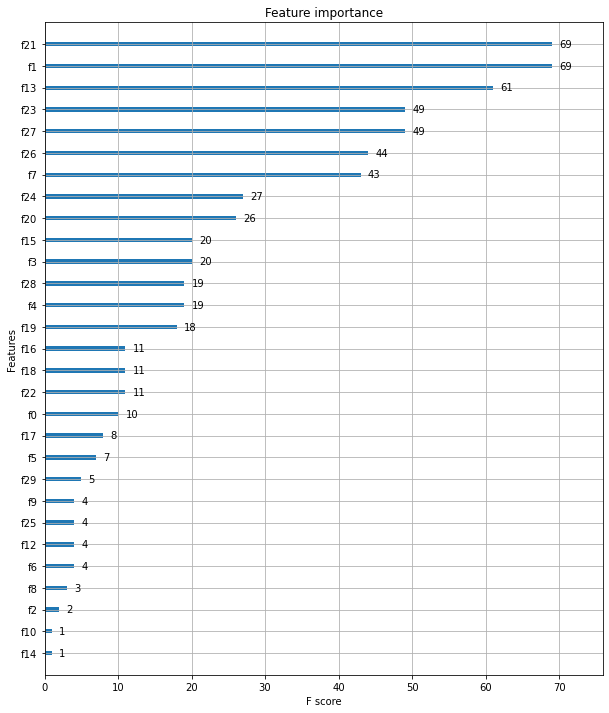

In [148]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_model,ax)

추가로 , 파이썬 래퍼 xgboost 는 교차 검증 수행 및 최적 파라미터 구하기 위해 
<u>사이킷런의 GridSearchCV 와 유사하게 cv( )를 API로 제공한다.</u> <br>( 자세한 부분은 p.240 참고 )

### 사이킷런 래퍼 XGBoost 

사이킷런의 기본 Estimator 를 그대로 상속해서 만들어진 XGBoost 이기 때문에 동일하게 학습, 예측이 가능하다.<br>
분류에 사용 될 XGBClassifier 와 회귀에 사용 될 XGBRegressor 모두 지원한다.<br><br>
이번에도 마찬가지로 위스콘신 유방암 dataset 으로 예제를 진행하며, 파이썬 래퍼 XGBoost 와의 대표적인 파라미터 명칭 차이를 인식하자.
* eta → learning_rate
* sub_sample → subsample
* num_booast_round → n_estimators

학습, 테스트 데이터를 이어서 사용

In [167]:
from xgboost import XGBClassifier

sk_xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1,max_depth=3,random_state=110)
sk_xgb_wrapper.fit(X_train,y_train)
sk_xgb_pred = sk_xgb_wrapper.predict(X_test)
sk_xgb_pred_proba = sk_xgb_wrapper.predict_proba(X_test)[:,1]

classifier_evaluation(y_test,sk_xgb_pred,sk_xgb_pred_proba)

[16:21:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
오차 행렬
[[38  2]
 [ 0 74]]
정확도: 0.9825, 정밀도: 0.9737, 재현율: 1.0000, F1: 0.9867, AUC: 0.9916 




분리된 동일한 학습, 테스트 데이터를 썼기 때문에 같은 평가 지표 수치가 나온 것을 볼 수 있다.<br><br>
사이킷런 래퍼 XGBoost 도 조기 중단 파라미터를 사용 할 수 있다. <br>다만, 앞선 파이썬 래퍼와 유사하게 학습을 위한 함수 fit() 에 
<u>early_stopping_rounds</u> , <u>eval_metric</u> , <u>eval_set</u> 파라미터 들을 설정 해주어야 한다.<br><br>
<span style="color:red">주의. 현 예제에서 평가를 수행 할 평가용 데이터 세트인 eval_set 으로 테스트 데이터를 사용했지만, 이렇게 학습 과정에서 테스트 데이터를 써버리면 나중에 predict() 에서 테스트 데이터를 썼을 때 과적합이 생길 수 있어서, 테스트 데이터는 학습 시에 완전히 알려지지 않은 데이터 세트를 사용해야 한다.</span>

In [168]:
sk_xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1,max_depth=3)

evals = [(X_test,y_test)]

sk_xgb_wrapper.fit(X_train,y_train,early_stopping_rounds=100,eval_metric='logloss',eval_set=evals,verbose=True)

# 조기 중단 100 일 때 예측 
ws100_pred = sk_xgb_wrapper.predict(X_test)

# 조기 중단 100 일 때 positive 레이블 예측 확률로 예측  
ws100_pred_proba = sk_xgb_wrapper.predict_proba(X_test)[:,1]

[0]	validation_0-logloss:0.61206
[1]	validation_0-logloss:0.54471
[2]	validation_0-logloss:0.48973
[3]	validation_0-logloss:0.44188
[4]	validation_0-logloss:0.40094
[5]	validation_0-logloss:0.36566
[6]	validation_0-logloss:0.33288
[7]	validation_0-logloss:0.30438
[8]	validation_0-logloss:0.28102
[9]	validation_0-logloss:0.25886
[10]	validation_0-logloss:0.23911
[11]	validation_0-logloss:0.22337
[12]	validation_0-logloss:0.20776
[13]	validation_0-logloss:0.19384
[14]	validation_0-logloss:0.18337
[15]	validation_0-logloss:0.17298
[16]	validation_0-logloss:0.16484
[17]	validation_0-logloss:0.15757
[18]	validation_0-logloss:0.14986
[19]	validation_0-logloss:0.14257
[20]	validation_0-logloss:0.13760
[21]	validation_0-logloss:0.13306
[22]	validation_0-logloss:0.12823
[23]	validation_0-logloss:0.12523
[24]	validation_0-logloss:0.12056
[25]	validation_0-logloss:0.11732
[26]	validation_0-logloss:0.11226
[27]	validation_0-logloss:0.10978
[28]	validation_0-logloss:0.10711
[29]	validation_0-loglos

n_estimators 를 400번으로 설정했으나, 조기 중단 파라미터가 100으로 되어 있기 때문에 100번씩 반복 할 때마다 logloss 값을 확인 하고 <br>개선의 여지가 없다 판단한 212번에서 중단 된 것을 볼 수 있다. 즉, 112 ~ 212 까지에서 성능 평가 지수가 향상 되지 않았기 때문에 반복을 그만 둔 것이다.<br><br>
해당 예측 값을 가지고 여러 가지 Evaluation 을 진행해보자.

In [169]:
classifier_evaluation(y_test,ws100_pred,ws100_pred_proba)

오차 행렬
[[38  2]
 [ 0 74]]
정확도: 0.9825, 정밀도: 0.9737, 재현율: 1.0000, F1: 0.9867, AUC: 0.9929 




위에서 조기 중단을 설정해주었을 때의 수치와 큰 차이는 나지 않는다.<br>
다만, 조기 중단 값을 너무 급격하게 줄이게 될 시 예측 성능이 저하 될 가능성이 있다. 예를 들어 조기 중단을 10으로 설정하였는데 반복을 하다가 50번이 넘는 시점에서 성능이 좋아 질 수 있음에도 그 전에 중단 될 수 있기 때문이다. <br><br> 한 번 확인해보자.

In [179]:
sk_xgb_wrapper.fit(X_train,y_train,early_stopping_rounds=5,eval_metric='logloss',eval_set=evals)

ws10_pred = sk_xgb_wrapper.predict(X_test)

ws10_pred_proba = sk_xgb_wrapper.predict_proba(X_test)[:,1]

[0]	validation_0-logloss:0.61206
[1]	validation_0-logloss:0.54471
[2]	validation_0-logloss:0.48973
[3]	validation_0-logloss:0.44188
[4]	validation_0-logloss:0.40094
[5]	validation_0-logloss:0.36566
[6]	validation_0-logloss:0.33288
[7]	validation_0-logloss:0.30438
[8]	validation_0-logloss:0.28102
[9]	validation_0-logloss:0.25886
[10]	validation_0-logloss:0.23911
[11]	validation_0-logloss:0.22337
[12]	validation_0-logloss:0.20776
[13]	validation_0-logloss:0.19384
[14]	validation_0-logloss:0.18337
[15]	validation_0-logloss:0.17298
[16]	validation_0-logloss:0.16484
[17]	validation_0-logloss:0.15757
[18]	validation_0-logloss:0.14986
[19]	validation_0-logloss:0.14257
[20]	validation_0-logloss:0.13760
[21]	validation_0-logloss:0.13306
[22]	validation_0-logloss:0.12823
[23]	validation_0-logloss:0.12523
[24]	validation_0-logloss:0.12056
[25]	validation_0-logloss:0.11732
[26]	validation_0-logloss:0.11226
[27]	validation_0-logloss:0.10978
[28]	validation_0-logloss:0.10711
[29]	validation_0-loglos

In [180]:
classifier_evaluation(y_test,ws10_pred,ws10_pred_proba)

오차 행렬
[[38  2]
 [ 1 73]]
정확도: 0.9737, 정밀도: 0.9733, 재현율: 0.9865, F1: 0.9799, AUC: 0.9932 




조기 중단을 5로 설정한 결과 조기 중단이 100 일 때보다 성능 평가 지표 값들이 미세하게 줄어든 것을 볼 수 있다.<br><br>
마지막으로 피처 중요도는 파이썬 래퍼 XGBoost 와 동일하게 사용한다.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

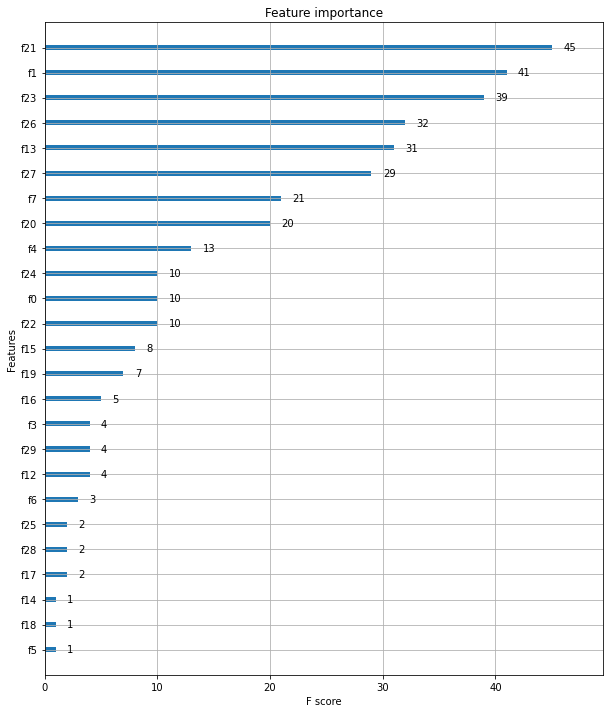

In [182]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(sk_xgb_wrapper,ax=ax)